# Part 0: Preliminary information

## Organization of the labs

Most lab sessions will be done based on Jupyter notebooks. The notebooks will be uploaded on StudIP. No preliminary preparation is needed. The notebook might be accompanied by a PDF for more theoretical questions. It is important to note that the labs are not only about coding, but mostly about understanding the concepts of the course and thinking on formalizing and solving problems.

The labs are **not** optional: they are part of the course, and some contents will be covered only there, not during the lectures. 

Attendance is not compulsory, but strongly encouraged. 

Some questions are left for the most curious of you. These questions are indicated with a **(!)** symbol. Do not solve them during the session. These questions are optional but not graded.  


## Prerequisites

* Python 3.7 or newer
* Packages numpy and matplotlib

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from enum import Enum
from random import sample
import copy
from copy import deepcopy
from collections import deque
import matplotlib.pyplot as plt

# Part 1: The monkey and banana environment

In this session, we explore the problem of the monkey and the banana introduced in the first lecture. This example will be a recurrent example all along the lecture: it has all the characteristics of a real AI problem, but its small size makes it easier to test methods on it. 

In this problem, the agent is a monkey whose goal is to grab a banana hanging from the ceiling. The monkey can reach the banana by climbing upon a box.

## First contact with the environment

The environment is fully defined with the following three classes.

* ```MonkeyBananaState```: Implementation of a state of the environment, namely the horizontal position of the box (integer), the horizontal position of the banana (integer) and the vertical position of the monkey (Boolean). Note that the position of the monkey describes whether the monkey is on the box (value equals ```True```) or on the floor (value equals ```False```)

In [5]:
@dataclass
class MonkeyBananaState:
    """
    Class describing states of the environment. A state is given by the
    position of the box, the position of the banana and the position of
    the monkey. 
    """
    box_position: int
    banana_position: int
    is_monkey_up: bool
    
    def vector_representation(self):
        return (self.box_position, self.banana_position, self.is_monkey_up)

For instance, you can define a state where the box is in cell 1, the banana in cell 2 and the monkey on the box as follows:

In [6]:
state = MonkeyBananaState(1, 2, True)
print(state)

MonkeyBananaState(box_position=1, banana_position=2, is_monkey_up=True)


* ```MonkeyBananaAction```: Enumeration of the potential actions of the monkey. Note that this set of actions is fixed, but that in practice all of them won't be necessarily available to the agent. Determining which actions are available in which state is the responsibility of the environment class itself.

In [7]:
class MonkeyBananaAction(Enum):
    GRAB           = 0
    CLIMB          = 1
    GO_DOWN        = 2
    MOVE_BOX_LEFT  = 3
    MOVE_BOX_RIGHT = 4

* ```MonkeyBananaEnvironmentTask```: Main implementation of the environment task. This class contains all the methods relative to the task and to the interaction between the agent and the environment.

The first two important methods to consider are the constructor and the visualization (```visualize```). The constructor instantiates an environment of a given size (i.e. a given number of positions on the horizontal axis), given by the room size argument, and the initial position of the banana and of the box. The monkey is assumed to be initially on the floor. The visualization method provides a simple visual representation representation of the room.

Note that the notion of task here also incorporates the *objective* of the agent, which is here described as a score. We introduce the parameters of the score:

In [8]:
# Parameters for the score

ACTION_PENALTY = .1
GRAB_BANANA_REWARD = 5
GRAB_ORANGE_REWARD = 2

and the main definition of the task:

In [9]:
class MonkeyBananaEnvironmentTask:
    """
    Description of the general environment of the monkey and banana problem
    """
    
    
    def __init__(self, initial_banana_position: int, initial_box_position: int, room_size: int = 5):
        
        assert (initial_banana_position >= 0 and initial_banana_position < room_size), \
            "Banana position must be between 0 and the room size"
            
        assert (initial_box_position >= 0 and initial_box_position < room_size), \
            "Box position must be between 0 and the room size"
        
        self.score = 0
        self.state = MonkeyBananaState(initial_box_position, initial_banana_position, False)
        self.room_size = room_size
    
    
    def _is_box_under_banana(self):
        return self.state.banana_position == self.state.box_position
    
    def visualize(self):
        level_2 = [" "] * (self.room_size * 2 - 1)
        level_2[self.state.banana_position * 2] = '🍌'


        if self.state.is_monkey_up:
            level_1 = [" "] * (self.room_size * 2 - 1)
            level_1[self.state.box_position * 2] = '🐒'
        else: 
            level_1 = [" "] * (self.room_size * 2)
        
        if not self.state.is_monkey_up:
            level_0 = [" "] * (self.room_size * 2 - 2)
            level_0[max(self.state.box_position * 2 - 1, 0)] = '██'
        else:
            level_0 = [" "] * (self.room_size * 2 - 1)
            level_0[self.state.box_position * 2] = '██'
        
           
        if not(self.state.is_monkey_up):
            if self.state.box_position == 0:
                level_0[1] = '🐒'
            else:
                level_0[0] = '🐒'
        
        box_top =    ["─" * self.room_size * 2]
        box_bottom = ['─' * self.room_size * 2]
        
        box_top =    ['┌'] + box_top +    ['┐']
        level_2 =    ['|'] + level_2 +    ['|']
        level_1 =    ['|'] + level_1 +    ['|']
        level_0 =    ['|'] + level_0 +    ['|']
        box_bottom = ['└'] + box_bottom + ['┘']

        print('\n')
        print('   ', ''.join(box_top))
        print('   ', ''.join(level_2))
        print('   ', ''.join(level_1))
        print('   ', ''.join(level_0))
        print('   ', ''.join(box_bottom))
        print('\n')
    
    
    def performance(self):
        return self.score
    
    
    def available_actions(self):
        if self.state.is_monkey_up:
            return [MonkeyBananaAction.GO_DOWN, 
                    MonkeyBananaAction.GRAB]
        else:
            return [MonkeyBananaAction.MOVE_BOX_LEFT, 
                    MonkeyBananaAction.MOVE_BOX_RIGHT,
                    MonkeyBananaAction.GRAB,
                    MonkeyBananaAction.CLIMB]
    
    
    
    def perform_action(self, action: MonkeyBananaAction):
        if action == MonkeyBananaAction.GRAB:
            if self.state.is_monkey_up and self._is_box_under_banana():
                self.score += GRAB_BANANA_REWARD
                return True
            else:
                self.score -= ACTION_PENALTY
            
        elif action == MonkeyBananaAction.CLIMB:
            self.score -= ACTION_PENALTY
            self.state.is_monkey_up = True
            
        elif action == MonkeyBananaAction.GO_DOWN:
            self.score -= ACTION_PENALTY
            self.state.is_monkey_up = False
            
        elif action == MonkeyBananaAction.MOVE_BOX_LEFT:
            self.score -= ACTION_PENALTY
            if self.state.box_position > 0:
                self.state.box_position = self.state.box_position - 1
        
        elif action == MonkeyBananaAction.MOVE_BOX_RIGHT:
            self.score -= ACTION_PENALTY
            if self.state.box_position < self.room_size - 1:
                self.state.box_position = self.state.box_position + 1
            
        return False
    
    
    def perceive(self):
        pass

### Question 1:

Get familiar with this environment, by instantiating an environment of size 10
in which the box is located at x = 2 and the banana at x = 4. Visualize this environment.

In [10]:
#Initialize the environment
env = MonkeyBananaEnvironmentTask(2, 4, 10)
env.visualize()



    ┌────────────────────┐
    |    🍌              |
    |                    |
    |🐒      ██          |
    └────────────────────┘




In any state the list of available actions can be retrieved using the ```available_actions``` method. Once the agent selects its action, it can perform it within the environment using the ```perform_action``` method. The method outputs a Boolean which indicates whether the monkey successfully grabbed the banana.

### Question 2 
Using the environment instantiated in Question 1, write a series of actions that should lead the agent to grabbing the banana. Check that it is successful by implementing it. Using the performance method, compute the score of the agent.

In [11]:
print("Actions available to the agent:", env.available_actions())

Actions available to the agent: [<MonkeyBananaAction.MOVE_BOX_LEFT: 3>, <MonkeyBananaAction.MOVE_BOX_RIGHT: 4>, <MonkeyBananaAction.GRAB: 0>, <MonkeyBananaAction.CLIMB: 1>]


In [12]:
#Provided SubOptimal Sequence of Actions
env.perform_action(MonkeyBananaAction.MOVE_BOX_LEFT)
env.visualize()
env.perform_action(MonkeyBananaAction.GRAB)



    ┌────────────────────┐
    |    🍌              |
    |                    |
    |🐒    ██            |
    └────────────────────┘




False

In [13]:
#OPTIMAL SEQUENCE

#Renitialize the environment
env = MonkeyBananaEnvironmentTask(2, 4, 10)
env.visualize()

#Initial Step - Given
env.perform_action(MonkeyBananaAction.MOVE_BOX_LEFT)
print(env.score)
env.perform_action(MonkeyBananaAction.MOVE_BOX_LEFT)
print(env.score)
env.perform_action(MonkeyBananaAction.CLIMB)
print(env.score)
env.perform_action(MonkeyBananaAction.GRAB)
print(env.score)
env.visualize()



    ┌────────────────────┐
    |    🍌              |
    |                    |
    |🐒      ██          |
    └────────────────────┘


-0.1
-0.2
-0.30000000000000004
4.7


    ┌────────────────────┐
    |    🍌              |
    |    🐒              |
    |    ██              |
    └────────────────────┘




Some series of actions are sub-optimal, in the sense that they lead to the goal but with a potentially high number of unnecessary actions. For instance, the monkey can start moving the box to the left then to the right. This is sub-optimal because it leads back to the initial state after two actions which are then useless.

### Question 3

Is the sequence of actions found in the previous question optimal or suboptimal? Is there a unique optimal sequence of actions? Prove the result.

*Rough Answer* - The provided sequence of actions in the previous question is not optimal as the monkey is not able to grab the banana at any point at or before, the final step.

An optimal sequence of actions can be given by the steps below - 
1. MOVE BOX LEFT (-0.1 Score)
2. MOVE BOX LEFT (-0.1 Score)
3. CLIMB (-0.1 Score)
4. GRAB (+5 Score)



We can use a BFS algorithm to iterate in the state search space to work out the optimal sequence of actions. If there is only one such solution, it is then by definition unique. *Working on the proof with rigor*.

Intuition - BFS will reach all possible states in the search space, for a finite deterministic system such as this. If BFS finds a sequence of actions that lead to it grabbing the banana, if this is the first sequence that is so - it must be the shortest path, since a shorter path would have been found earlier. 

*Need to work out the implementation considerations.*

## Fully vs partially observable environment

A third essential component of a task is the perception, i.e. what of the total environment, can be observed by the agent. This is implemented in method perceive, which is left abstract in the ```MonkeyBananaEnvironmentTask``` class. Two variants are proposed: a variant for fully observable environments, and a specific partially observable environment.

In a fully observable environment task, the agent perceives the entire state of the environment. This is implemented within the ```MonkeyBananaFOEnvironmentTask```, which is a child class of ```MonkeyBananaEnvironmentTask```. Here the perceive method returns the full state.

In [14]:
class MonkeyBananaFOEnvironmentTask(MonkeyBananaEnvironmentTask):
    """
    Fully observable environment
    """
    
    def perceive(self):
        """
        In the fully observable environment, the agent observes the whole state
        """
        return self.state
    

In a partially observable environment task, the agent does not perceive the exact state. We assume that, in this environment, the monkey can smell the banana when on top of the box. A full description of the probability is given in the last part of the lab session. The observation then describes the position of the box, the position of the monkey, and whether the
monkey can smell the banana. It is implemented in class ```MonkeyBananaPartialObservation```. The class ```MonkeyBananaPOEnvironmentTask``` is an implementation of the corresponding environment
task.

In [15]:
@dataclass
class MonkeyBananaPartialObservation:
    """
    Class describing the perceived state of the environment, when the position
    of the banana is not visible by the monkey. Only the position of the box 
    and of the monkey are visible. But the monkey can smell the banana
    """
    box_position: int
    is_monkey_up: bool
    smells_banana: bool
        
class MonkeyBananaPOEnvironmentTask(MonkeyBananaEnvironmentTask):
    """
    Partially observable environment
    """
    
    def perceive(self):
        """
        In the partially observable environment, the agent does not observe the 
        position of the banana, but can smell the banana. 
        """
        smells_banana = False
        
        proba_smell =  1 / (1 + SMELL_ALPHA * (self.state.banana_position - self.state.box_position)**2)
        
        if self.state.is_monkey_up and np.random.rand() < proba_smell:
            smells_banana = True
            
            
        return MonkeyBananaPartialObservation(self.state.box_position, 
                                              self.state.is_monkey_up, 
                                              smells_banana)
    

**In the following, we propose several strategies to solve the problem. Feel free to explore them in the order you want!**

The generic code for an agent is given in the class ```Agent```:

In [ ]:
class Agent:
    """
    General abstract class for an agent.
    """
    
    def choose_action(self, env: MonkeyBananaEnvironmentTask, verbose:str = True):
        """
        (Abstract) Implements the choice of action for the specific agent. 

        Parameters
        ----------
        env : MonkeyBananaEnvironmentTask
            Current environment.
        verbose : str, optional
            Allow logs. The default is True.

        Returns
        -------
        action: MonkeyBananaAction
            Returns the optimal action.

        """
        pass
    
    
    
    def run(self, env: MonkeyBananaEnvironmentTask, n_steps: int, verbose: bool = True):
        if verbose:
            env.visualize()

        for n in range(n_steps):
            if verbose:
                print("\n======= Step", n)
            action = self.choose_action(env, verbose)
            if verbose:
                print("\nAction:", action, "\n")

            res = env.perform_action(action)
            if res:
                if verbose:
                    print("Victory!")
                    print("Total score:", env.performance())
                    print("Steps Needed:", n)
                return (env, n)  

            if verbose:
                env.visualize()

        return (env, n_steps)

# Part 2: Random agent

The simplest possible agent is a fully random agent. Such an agent makes its decision uniformly at random at each time step, among the available actions.

In [48]:
class RandomAgent(Agent):
    """
    Random agent (Section 3)
    """
    
    def choose_action(self, env: MonkeyBananaEnvironmentTask, verbose:str):
        available_actions = env.available_actions()
        action = sample(available_actions, 1)[0]
        return action

### Question 4

Run 100 random agents and measure the number of steps needed to grab the
banana. Compute the average number of steps and plot the distribution. How many agents
do find the optimal trajectory?

Running for step limit: 50
Running for step limit: 100
Running for step limit: 1000
Running for step limit: 5000
Running for step limit: 10000


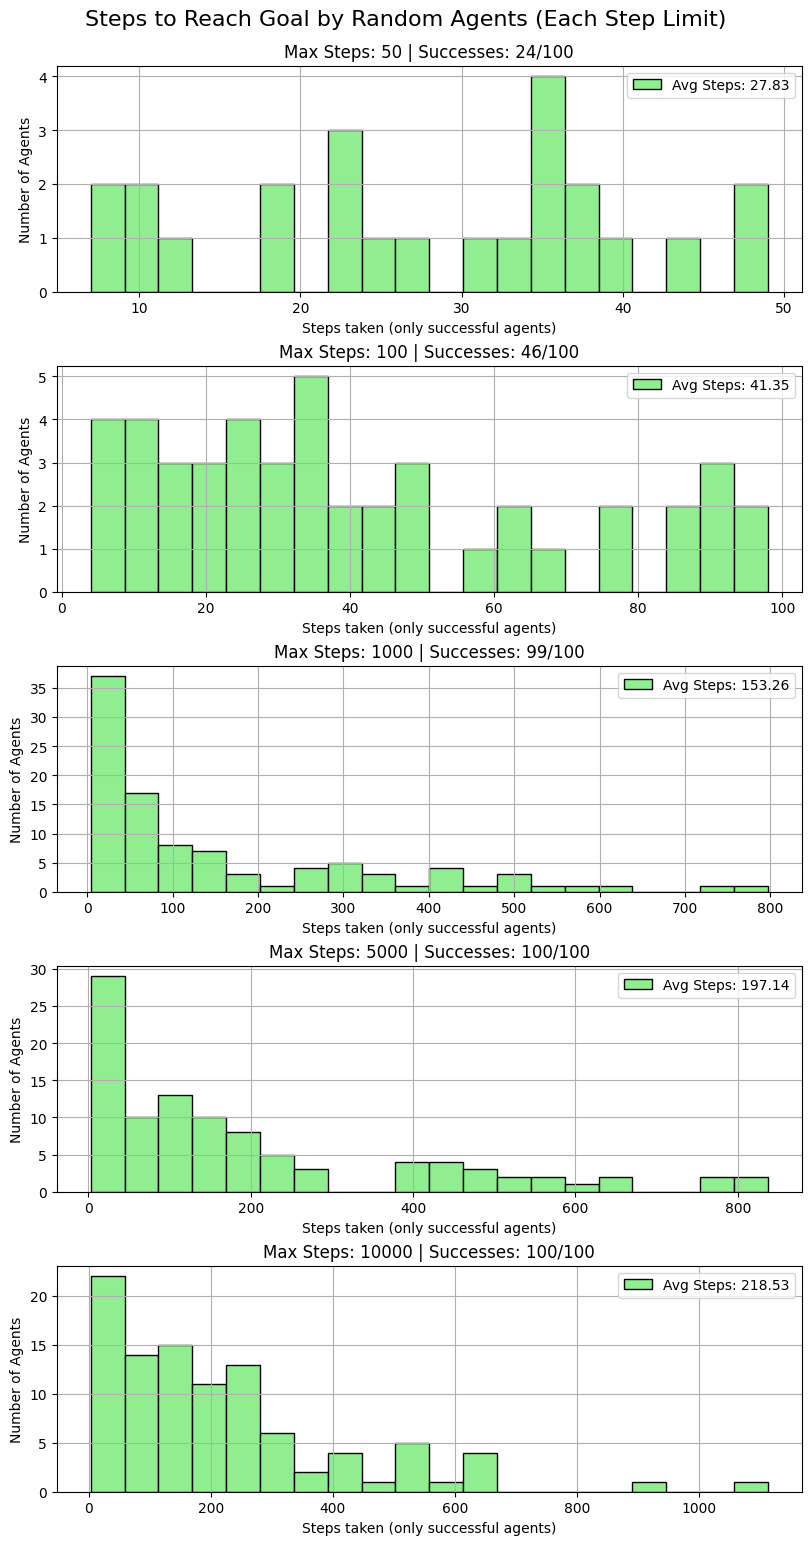

In [59]:
# Step limits to evaluate
step_limits = [50, 100, 1000, 5000, 10000]
num_agents = 100

# Data storage
results = {}

for n_steps in step_limits:
    print(f"Running for step limit: {n_steps}")

    agents = [RandomAgent() for _ in range(num_agents)]
    successful_steps = []

    for agent in agents:
        agent_env = copy.deepcopy(env)
        final_env, steps_taken = agent.run(agent_env, n_steps, verbose=False)

        # If the agent finished before exhausting all steps, it succeeded
        if steps_taken < n_steps:
            successful_steps.append(steps_taken)

    results[n_steps] = {
        "success_steps": successful_steps,
        "avg_steps": sum(successful_steps) / len(successful_steps) if successful_steps else None,
        "num_successful": len(successful_steps)
    }

# Plotting each scenario in its own subplot
fig, axes = plt.subplots(len(step_limits), 1, figsize=(8, len(step_limits) * 3), constrained_layout=True)

for idx, n_steps in enumerate(step_limits):
    stats = results[n_steps]
    ax = axes[idx]

    if stats["success_steps"]:
        ax.hist(stats["success_steps"], bins=20, color='lightgreen', edgecolor='black')
        legend_label = f"Avg Steps: {stats['avg_steps']:.2f}"
    else:
        ax.text(0.5, 0.5, "No successful agents", ha='center', va='center', fontsize=12, transform=ax.transAxes)
        legend_label = "No successes"

    ax.set_title(f"Max Steps: {n_steps} | Successes: {stats['num_successful']}/{num_agents}")
    ax.set_xlabel("Steps taken (only successful agents)")
    ax.set_ylabel("Number of Agents")
    ax.legend([legend_label])
    ax.grid(True)

plt.suptitle("Steps to Reach Goal by Random Agents (Each Step Limit)", fontsize=16, y=1.02)
plt.show()

For different step count limits, we can observe the values computed in the above graph with respect to average step count, and number of agents that succeed.
Loosely, it seems that with a larger step count, a higher number of agents reach the goal - and for these larger counts (1000 and so on), the average step count is around the 150 - 250 mark.

## Theoretical analysis (optional)

In the following part, we will prove that the random agent ends up grabbing the banana with a probability of 1 if we wait long enough. This part is more advanced, fully optional, and not to be done during the session. Feel free to come ask me for help after the lectures if you are stuck! 


### Question 5.1 (!)
What is the probability that the agent performs the optimal sequence of actions? Is this agent rational?

*Proposed Answer* - (Inferred from Slides) - abs(b-x)
- Intuition - This should be a product of probabilities that cumulatively indicate the chance that the optimal sequence is chosen.
If an optimal path has step k0 to kn, it would be, cumulative product of (probability that step k0 is chosen)*(probability that step k1 is chosen)*....*(probability that step kn is chosen)*1.
The definition of a rational agent is that - for each possible sequence of past percepts and actions, the agent selects an action that is expected to maximise its performance measure, given the evidence provided by the history and the built in knowledge that it has. Since a random selection of choices inherently does not take the past choices into account, it is then by definition an irrational agent that has this strategy.


We will now propose a lower bound of the probability that the agent reaches the banana before time $t$. To do so, we will decompose the trajectory into several segments. 

### Question 5.2 (!)
Knowing that the box starts at position $x \in \mathbb{N}$ and that the banana is at position $b \in \mathbb{N}$, what is the optimal trajectory? What is the probability that the random agent plays this exact trajectory?

*Proposed Answer* - (Inferred from Slides)
- Depending on if b-x is positive (banana on right of box), or negative (banana on left of box) - the optimal trajectory is then to select the appropriate number of steps (unidirectionally left or right based on (b-x) value).
- Next Step - Climb on Box
- Next Step - Grab Banana
- So ideally this would be a product of the probabilities of the steps (1/5) for each step. This explanation/solution attempt presumes the monkey is never already on the box. Mathematical Proof required.

### Question 5.3 (!)

We denote by $T$ the length of this trajectory. Show that for all $t < T$, the probability of victory is 0. What is the probability of victory at time $t = T$? Propose a lower bound and an upper bound of this probability that does not depend on $x$ and $b$ (but can depend on the length $L$ of the environment). 

In other words, if we wait until time $T$, either the agent just grabs the banana, or we know that the agent did not grab the banana. We know the exact probability of these two events. In case the agent did not grab the banana, we can run the process again. 

We now use the following notations. We call a *state* the tuple $s = (x, m)$ where $x \in \mathbb{N}$ is the position of the box and $m \in \lbrace 0, 1 \rbrace$ is the position of the monkey (0 = down, 1 = up). We designate by $s_{t}$ the state at time $t$. We designate by $v_t \in \lbrace 0, 1 \rbrace$ the victory status. We note by $T_1$ the length of the optimal trajectory starting from $s_0$. 

In Question 5.3, we have proven the existence of $0 < m, M < 1$, depending on the length $L$ of the environment only, and such that
$$
    m \leq p(v_{T_1} = 1 \ | \ s_0) \leq M.
$$
Starting from state $s_{T_1}$, we can use the same reasoning: there is a unique optimal trajectory leading to victory. We call $T_2$ the time step where this trajectory ends. 

### Question 5.4 (!)

At which time steps~$t \leq T_2$ do we have $p(v_t = 1 \ | \ s_0) > 0$? We denote by $p_2$ the probability that the agent grabs the banana at latest at $t = T_2$. Show that
$$
p_2 = p(v_{T_1} = 1 \ | \ s_0) + p(v_{T_1} = 0 \ | \ s_0) \ p(v_{T_2} = 1 \ | \ v_{T_1} = 0, s_0)
$$


### Question 5.5 (!)

Compute lower and upper bounds for $p(v_{T_2} = 1 \ | \ s_1)$. By marginalizing over $s_1$, show that 
$$
m \leq p(v_{T_2} = 1 \ | \ v_{T_1} = 0, s_0) \leq M.
$$

We can continue the process. For all $k$, we denote by $T_k$ the process where the $k$-th optimal trajectory ends (meaning that the first $k-1$ trajectories were not optimal; in case the optimal trajectory was reached already, we simply take $T_{k} = T_{k-1} + 1$). We denote by $p_k$ the probability that the banana was grabbed before time step $T_k$. 

### Question 5.6 (!)
Show that
$$
p_{k+1} = p_k + (1 - p_k) \ p(v_{T_{k+1}} = 1 \ | \ v_{T_{1}} = \dotsc = v_{T_{k}} = 0, s_0).
$$
and deduce that $(p_k)$ converges toward a finite limit $\ell \in (0, 1]$. Observing that the convergence of $(p_k)$ implies that $| p_{k+1} - p_k | \rightarrow 0$ and using the same reasoning as in Question 5.5, show that $\ell = 1$.

# Part 3: Simple reflex rule-based agent

A rule-based agent takes actions by following a predefined set of (deterministic) rules. Such an agent is implemented in the class ```RuleBasedAgent```. When choosing the actions, the rule-based agent first observes the environment, and then obeys a series of rules.

### Question 6

Execute the currently implemented rules. What is the behaviour of the agent.
Implement a set of rules that guarantee the agent to follow the optimal trajectory.

In [ ]:
class RuleBasedAgent(Agent):
    """
    Reflex rule-based agent (Section 4)
    """
    
    def choose_action(self, env: MonkeyBananaFOEnvironmentTask, verbose:str):
        
        observation = env.perceive()
        
        # TODO: Question
        
        if observation.is_monkey_up:
            return MonkeyBananaAction.GO_DOWN
        else:
            return MonkeyBananaAction.MOVE_BOX_LEFT

The main problem with rule-based systems is that they require to have a predefined set of rules. In many situations, such rules are not easy to define for the user. This is the reason why most AI techniques aim to be autonomous enough and to avoid relying on some predefined knowledge of the developer.

# Part 4: Planning agent

The planning agent implemented in class ```PlanningAgent``` explores several potential paths to get to the banana. At each time step, the agent simulates the result of all potential actions it can make, which results in a foreseen future environment (variable ```env_copy```). The planning is then called recursively from this new state. Such a search is called depth-first search.


In [ ]:
class PlanningAgent(Agent):
    """
    Planning agent (Section 5)
    """
    
    def _launch_planning(self, env: MonkeyBananaFOEnvironmentTask):
        """
        Method used to launch the planning. To be used only withing choose_action

        Parameters
        ----------
        env : MonkeyBananaFOEnvironmentTask
            Environment in the initial state.

        Returns
        -------
        plan_found: bool
            Shows whether the planning was succesful.
        action: MonkeyBananaAction
            Returns the optimal action

        """
        encountered_states = set()
        return self._plan(env, encountered_states)
        
        
    
    def _plan(self, env: MonkeyBananaFOEnvironmentTask, encountered_states: set):
        """
        Private method used to execute the planning recursively

        Parameters
        ----------
        env : MonkeyBananaFOEnvironmentTask
            Environment.
        encountered_states : set
            States that have already been explored by the search.

        Returns
        -------
        plan_found: bool
            Shows whether the planning was succesful.
        action: MonkeyBananaAction
            Returns the optimal action.

        """
        
        perceived_state_representation = env.perceive().vector_representation()
        
        # TODO: Question 12
        
        encountered_states.add(perceived_state_representation)
        
        
        available_actions = env.available_actions()
        
        for action in available_actions:
            # Makes a copy of the environment => This copy is used to then execute
            # the planning recursively from the new state reached after playing
            # the explored action
            env_copy = deepcopy(env)
            
            # Execute the action within the copied environment. 
            victory = env_copy.perform_action(action)
            
            if victory:
                # This action led to victory => planning is over!
                return True, action
            
            new_state = env_copy.perceive().vector_representation()
            
            encountered_states_copy = deepcopy(encountered_states)
            # Execute the search recursively from the new state
            plan_found, _ = self._plan(env_copy, encountered_states_copy)
                
            if plan_found: return True, action
        
        return False, None
    
    def choose_action(self, env: MonkeyBananaFOEnvironmentTask, verbose:str):
        plan_found, action = self._launch_planning(env)
        
        if plan_found:
            return action
        else:
            print("no plan found")
            available_actions = env.available_actions()
            action = sample(available_actions, 1)[0]
            return action

### Question 7

Launch an instance of the planning agent. You can observe that the search enters an infinite loop. Can you explain why? Fix the code to make the agent avoid infinite loops.


# Part 5: A Bayesian rule-based agent

We consider a variant of the environment where the agent has partial observability: It knows the position of the box and its own position, but ignores the position of the banana. Otherwise, the rules of the environment are exactly the same: in particular, the monkey can grab the banana when on top of the box and under the banana.

### Question 8

Which of the previous three agents can work in this variant?

**The following questions are more advanced, and therefore optional.**

We propose a new agent adapted to this setting of partial observability. In this context, the agent does not know the location of the banana but has to guess it. In practice, this means that the agent will observe the environment and build some *belief* about the location of the banana. A belief is defined as a probability distribution over the states of the environment. Here, since the location of the box and of the monkey are known, there is then a finite number of states $s_1, \dotsc, s_L$ which correspond to each possible position of the banana (in state $s_i$, the banana is located at $i$). Consequently, the belief sums up to a probability distribution over the location of the banana. It is then a vector $\pi$ of dimension $L$ such that
$$
    \sum_{i=1}^L \pi_i = 1
$$

If the agent knows that the banana is located in $b$, it would correspond to having a belief $\pi$ such that $\pi_b = 1$ and $\pi_i = 0$ for all $i \neq b$. Conversely, if the agent has absolutely no idea where the banana is located, its belief would be uniform: $\pi_1 = \dotsc = \pi_L = \frac{1}{L}$.

### Question 9.1 (!)

Given a state $s_i$, it is easy to model the observations $o$ made by the agent, using probability $p(o \ | \ s_i)$. This however does not provide any (direct) information on the probability of $s_i$. Using Bayes rule and assuming the belief $\pi_i$, express the quantity $p(s_i \ | \ o)$ for the agent, i.e. the belief that the environment is in state $s_i$, as a function of $p(o \ | \ s_1), \dotsc, p(o \ | \ s_L)$ and $\pi$ only.


At each step~$t$, after performing an action, the agent gets a new observation $o_t$ and updates its belief by taking $\pi \gets p(s_i \ | \ o_t)$. This belief update method is called *Bayesian belief update*. In the expression found in Question 9.1:

* The term $\pi_i$ is called the *prior*: it measures the belief that the agent has in each state *before* any new observation;
* The term $p(o \ | \ s_i)$ is called the *likelihood*: it measures how *likely* every possible observation is according to each state;
* The term $p(s_i \ | \ o)$ is called the *posterior*: it measures the belief that the agent has in each state *after* it got the new observation

We consider that the monkey cannot see the banana, but only smell it when on top of the box. When the monkey is on the box, it can smell the banana with a probability $\frac{1}{1 + \alpha |x - b|^2}$ where $\alpha$ is some sensitivity parameter, $x$ is the position of the box and $b$ is the position of the banana.

### Question 9.2 (!)

Implement the Bayesian belief update for the ```BayesianAgent``` class, in the method ```update_belief```, with the proposed likelihood.


In [ ]:
class BeliefAgent(Agent):
    """
    Bayesian rule-based agent (Section 6)
    """
    
    def __init__(self, env_size: int):
        self.env_size = env_size
        self.beliefs = np.ones(env_size) / env_size


    def update_belief(self, obs: MonkeyBananaPartialObservation):
        if not(obs.is_monkey_up): 
            # Monkey is not on the box => no update
            return 
        
        # TODO: 9.1: Implement Bayesian belief update here
        self.beliefs = self.beliefs 

    
    def choose_action(self, env: MonkeyBananaPOEnvironmentTask, verbose:str):
        # TODO: Question 9.2
        if np.any(self.beliefs > 0.7):
            return None
        return None

    

Once the agent updates its beliefs, it must choose an action. Several options are possible here, but we choose to implement a simple strategy:
* If some state $s_i$ is associated to a belief $\pi_i > 0.7$, move the box to this position, climb and try to get the banana. 
* Otherwise move the box to any position with belief~$\pi_i > 0.2$ and climb. 

### Question 9.3 (!)

Implement this agent. Don't forget to change the belief update to take into account that $\pi_i = 0$ in case the monkey tried to grab the banana but did not succeed. 